In [5]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt  #Graphics
from sklearn. preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor  
np.random.seed(12345) 


### Load the data

Load the MNIST data set from two `.csv` files into two variables. 
Print the number of data points in the training and test sets.
Print the number of object in eacsh class.

In [3]:
train = pd.read_csv("data/mnist_train.csv")
train.dropna(inplace=True)
print(train.iloc[:,0].value_counts().sort_index())
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))

0    5923
1    6742
2    5958
3    6131
4    5842
5    5420
6    5918
7    6265
8    5851
9    5949
Name: 5, dtype: int64
Training dataset has 59999 observations and 785 variables


We normalize the pixel values using min-max normalization and reduce the dimensionality of the input.

In [6]:
def reduceDimensions(X, d):
    pca = PCA(n_components = d)
    pca.fit(X)
    return pca.transform(X)

def minMaxNormalize(X):
    return X/(np.max(X))

dataset = train
d = 20
df_x = minMaxNormalize(dataset.iloc[:,1:].to_numpy(dtype=float))
df_x = reduceDimensions(df_x, d)
df_y = dataset.iloc[:, 0].to_numpy(dtype=int)
print(df_y[0], df_x[0])        

0 [ 3.96750251 -1.15624131  2.33859716 -1.80690977 -3.24424117 -0.71367609
 -0.17645326 -0.41159013  0.15874318  0.59207142 -1.12364314 -0.42043535
 -1.25083141  0.35944812 -0.93183765 -0.63693025 -0.21445693  0.15937564
  0.21516056 -0.38398372]


### Slipt the data
Let us focus on the training data set. 
Split the 60000 observation into four equal-size random subsets, 
1. ${\cal D}_{train}$ to train the classifier,
2. ${\cal D}_{val}$ to train the localization function, 
3. ${\cal D}_{cal}$ to compute the quantiles,
4. ${\cal D}_{test}$ to evaluate the predictions sets.



In [7]:
indexes = np.random.choice(len(df_x), len(df_x), replace=False)
stops = [int(i * len(indexes)/4) for i in range(5)]
X, y = [df_x[indexes[stops[i]:stops[i + 1]]] for i in range(4)], [df_y[indexes[stops[i] : stops[i + 1]]] for i in range(4)]
print("data set shapes:")
names = ['train', 'val', 'cal', 'test']
for ix in range(len(X)):
    print(names[ix], X[ix].shape, y[ix].shape)
Xall, yall = X, y

data set shapes:
train (14999, 20) (14999,)
val (15000, 20) (15000,)
cal (15000, 20) (15000,)
test (15000, 20) (15000,)


### Train the classifier

Train a NN classifier on ${\cal D}_{train}$. 
The error rate on the four sets is resonable. 
We may increase the temperature using ``increaseTemperature`` if the classifier is too confident.
Set $T=0$ to leave the predicted probabilities unscaled.

In [8]:
def increaseTemperature(p, T):
    if T != 0:
        p = [[np.exp(f[i]/T) for i in range(len(p[0]))] for f in p]
    pt = [[s/sum(pi) for s in pi] for pi in p]
    return pt
iset = 0
T = 0
nn = RandomForestClassifier() 
nn.fit(Xall[iset], yall[iset])
print(nn)
for iset in range(4):   
    f = increaseTemperature(nn.predict_proba(Xall[iset]), T) 
    ER = 1 - sum([1 * (yall[iset][i] == np.argmax(f[i])) for i in range(len(f))])/len(f)
    print(names[iset], "ER =", ER)

RandomForestClassifier()
train ER = 0.0
val ER = 0.0716
cal ER = 0.07073333333333331
test ER = 0.0726


### Train the localizer 1

The goal is to train a series of label-conditional models such that 
$$
B|Y  = A|Y -  g_Y(X, f), \quad  g_Y(X, f) \sim A|Y
$$
or
$$
B|Y  = \frac{A|Y}{\gamma +  g_Y(X, f)}, \quad  g_Y(X, f) \sim A|Y
$$
We minimize 
$$
{\rm E}_{X|Y = y} \| g_y(X, f) - A|Y=y \|^2 
$$
for all $y=0, \dots, K$.

In [16]:
def entropy(p):
    return -np.sum(p * np.log(p + .001), axis=1)
    
def trainRegressor(a, z):
    g = RandomForestRegressor(n_estimators=20, bootstrap=True, max_depth=5, max_samples=100) 
    g.fit(z, a)
    return g

def prepareInput(model, x, y, T):
    f = np.array(increaseTemperature(model.predict_proba(x), T))
    X = np.array(x)
    Y = np.array(y)
    a = np.array([1 - f[i, Y[i]] for i in range(len(Y))])
    e = entropy(f)
    z = np.concatenate((np.ones([len(f), 1]), X, f, e.reshape(-1, 1)), axis = 1)
    return f, X, T, a, e, z
    
T = 0
model = nn
iset = 1
data = Xall[iset], yall[iset]
K = np.max(yall[iset]) + 1
G = []
for k in range(K):
    x = [data[0][i] for i in range(len(data[0])) if data[1][i] == k]
    y = [data[1][i] for i in range(len(data[1])) if data[1][i] == k]
    f, X, T, a, e, z = prepareInput(nn, x, y, T)
    print(f[0])
    g = trainRegressor(a, z)
    s = g.predict(z)
    print("train RSS ("+str(k)+","+str(len(a))+")=", iset, sum((a - s)**2)/len(a))
    G.append(g)

[0.95 0.   0.03 0.   0.   0.01 0.   0.   0.   0.01]
train RSS (0,1524)= 1 0.00017026812228433156
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train RSS (1,1749)= 1 0.0011039035582943767
[0.   0.01 0.96 0.03 0.   0.   0.   0.   0.   0.  ]
train RSS (2,1551)= 1 0.00014340416583193827
[0.   0.01 0.06 0.28 0.   0.2  0.   0.01 0.41 0.03]
train RSS (3,1474)= 1 0.00010641628538270574
[0.   0.   0.   0.01 0.91 0.   0.   0.   0.   0.08]
train RSS (4,1370)= 1 0.00014431099339237382
[0.01 0.01 0.01 0.59 0.   0.33 0.01 0.03 0.   0.01]
train RSS (5,1379)= 1 9.959204367468842e-05
[0.   0.   0.02 0.   0.03 0.01 0.92 0.01 0.   0.01]
train RSS (6,1464)= 1 0.00028636334698023473
[0.   0.   0.   0.   0.   0.02 0.   0.94 0.01 0.03]
train RSS (7,1533)= 1 0.00011631525229090793
[0.06 0.03 0.04 0.34 0.   0.18 0.03 0.   0.29 0.03]
train RSS (8,1462)= 1 9.68895658421191e-05
[0.   0.   0.   0.03 0.07 0.   0.03 0.1  0.02 0.75]
train RSS (9,1494)= 1 0.00011787568032603293


We compute the class-conditional quantiles associated with the original and transformed calibration scores.
To obtain the transofrmed score for class $Y$ we use the corresponding localization function, $g_Y$.

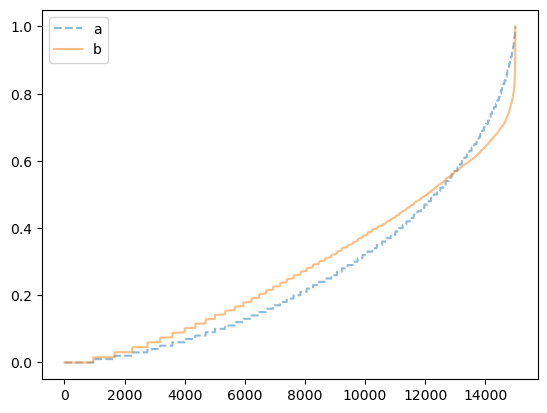

In [19]:
def Brf(s, a, gamma):
    return a/(gamma +  s)

def transformScores(G, f, z, a, gamma, k):
    if k != None:
        a = 1 - f[:, k]
        s = G[k].predict(z)
        b = Brf(s, a, gamma)
        return a, b
    else:
        si = [G[k].predict(z) for k in range(len(f[0]))]
        ai = [1 - f[:, k] for k in range(len(f[0]))]
        bi = [Brf(si[k], ai[k], gamma) for k in range(len(f[0]))]
        return ai, bi
        
def computeQuantiles(z, tryAlpha):
    z = np.sort(z, axis = 0)
    q = [z[[int(np.ceil((len(z) + 1) * (1 - alpha)))-1]] for alpha in tryAlpha]
    return q
        
tryAlpha = [.01 + i * 0.01 for i in range(20)]
eps = 1e-2
iset = 2
model = nn
data = Xall[iset], yall[iset]
gamma = 1
QA, QB = [], []
aAll,bAll = [], []
for k in range(len(f[0])):
    x = [data[0][i] for i in range(len(data[0])) if data[1][i] == k]
    y = [data[1][i] for i in range(len(data[0])) if data[1][i] == k]
    f, X, T, a, e, z = prepareInput(nn, x, y, T)
    a, b = transformScores(G, f, z, a, gamma, k)
    QA.append(computeQuantiles(a, tryAlpha))
    QB.append(computeQuantiles(b, tryAlpha))
    aAll.append(a.tolist())
    bAll.append(b.tolist())
asort = np.sort(sum(aAll, []), axis=0)
bsort = np.sort(sum(bAll, []), axis=0)
plt.plot(asort/max(asort), '--', alpha=0.5, label="a")
plt.plot(bsort/max(bsort), '-', alpha=0.5, label="b")
plt.legend()              
plt.show()


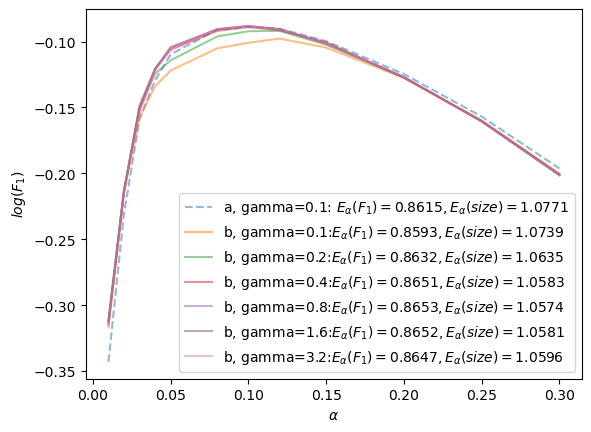

In [34]:
def evaluateIntervals(intervals, Y, k=None):
    TP, FP, TN, FN, F1 = 0, 0, 0, 0, 0
    if k != None:
        intervals = [intervals[i] for i in range(len(Y)) if Y[i] == k]
        Y = [Y[i] for i in range(len(Y)) if Y[i] == k]
    for i in range(len(intervals)):
        interval = intervals[i]
        y = Y[i]
        positives = [j for j in range(10) if j in interval]
        TP = TP + sum([1 for j in positives if j == y])
        FP = FP + sum([1 for j in positives if j != y])
        negatives = [j for j in range(10) if j not in interval]
        TN = TN + sum([1 for j in negatives if j != y])  
        FN = FN + sum([1 for j in negatives if j == y]) 
    F1 = 2 * TP/(2 * TP + FP + FN)
    val = TP/len(Y)
    size = TP + FP
    return TP, FP, TN, FN, F1, val, size




model = nn
tryAlpha = [.01, .02, .03, .04, .05, .08, .1, .12, .15, .2, .25, .30]
tryGamma = [.1, .2, .4, .8, 1.6, 3.2]#[.05, .1, .5, 1, 5]
for igamma in range(len(tryGamma)):
    gamma = tryGamma[igamma]
    
    iset = 2
    data = Xall[iset], yall[iset]
    QA, QB = [], []
    for k in range(len(f[0])):
        x = [data[0][i] for i in range(len(data[0])) if data[1][i] == k]
        y = [data[1][i] for i in range(len(data[0])) if data[1][i] == k]
        f, X, T, a, e, z = prepareInput(nn, x, y, T)
        a, b = transformScores(G, f, z, a, gamma, k)
        QA.append(computeQuantiles(a, tryAlpha))
        QB.append(computeQuantiles(b, tryAlpha))
    
    iset = 3
    x, y = Xall[iset], yall[iset]
    f, X, T, a, e, z = prepareInput(nn, x, y, T)
    ai, bi = transformScores(G, f, z, a, gamma, None)

    scores = [], []
    for ialpha in range(len(tryAlpha)):
        k = np.random.randint(len(x))
        alpha = tryAlpha[ialpha]
        intervalsA = [[j for j in range(len(ai)) if ai[j][i] <= QA[j][ialpha]] for i in range(len(ai[0]))]
        intervalsB = [[j for j in range(len(bi)) if bi[j][i] <= QB[j][ialpha]] for i in range(len(bi[0]))]
        ndiff = sum([1 for i in range(len(intervalsA)) if len(intervalsA[i]) !=len(intervalsB[i])])
        #print("alpha="+str(alpha)+", gamma="+str(gamma)+", diff="+str(ndiff))  
        intervalsAll = intervalsA, intervalsB
        for iModel in [0, 1]:
            TP, FP, TN, FN, F1, val, size = evaluateIntervals(intervalsAll[iModel], y, None)
            scores[iModel].append([TP, FP, TN, FN, F1, val, size])
    F1s = [[scores[i][k][-3] for k in range(len(scores[i]))] for i in range(len(scores))]
    sizes = [[scores[i][k][-1]/len(intervalsA) for k in range(len(scores[i]))] for i in range(len(scores))]
    labelscore = ['$E_{\\alpha}(F_1)=$'+str(np.round(np.mean(F1s[i]), 4))+'$, E_{\\alpha}(size)=$'+str(np.round(np.mean(sizes[i]), 4)) 
                  for i in range(len(scores))]
    if (igamma == 0): plt.plot(tryAlpha, np.log(F1s[0]), '--', alpha=.5, label='a, gamma='+str(gamma)+': '+labelscore[0])
    plt.plot(tryAlpha, np.log(F1s[1]), '-', alpha=.5, label='b, gamma='+str(gamma)+':'+labelscore[1])
plt.legend()
plt.xlabel('$\\alpha$')
plt.ylabel('$log(F_1)$')
plt.show()
